# Density-Based Clustering

Previous clustering techniques we have seen, for example k-means, 
can create convex (generally round) clusters. Many times, clusters may have different shapes including non-convex shapes. 
In these cases, a local density measurement can provide a more robust determination of cluster membership.

Below is a sample data set that demonstrates the clusters with shapes other than round or convex. K-means would have hard time to find the "correct" clusters here. 


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



,x,y,shape
,<dbl>,<dbl>,<dbl>
1,-0.8037393,-0.8530526,1
2,0.8528507,0.3676184,1
3,0.9271795,-0.2749024,1
4,-0.7526261,-0.5115652,1
5,0.7068462,0.8106792,1
6,1.0346985,0.3946550,1


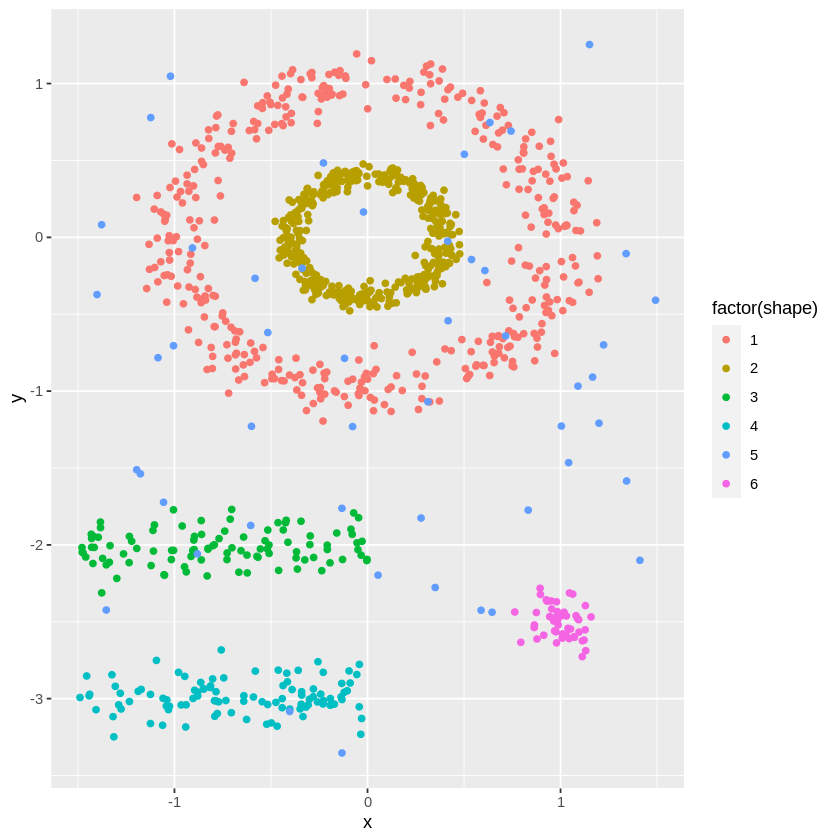

In [1]:
library(factoextra)
library(ggplot2)
data("multishapes", package = "factoextra")

head(multishapes)
ggplot(multishapes) + geom_point(aes(x=x,y=y, color=factor(shape)))

**DBSCAN** works by classifying points based on the characteristic of their local neighborhood. 
A point is a **core point** if a minimum number of points are within a given distance. 
These two parameters are algorithmically `eps` (or  $\epsilon$ ) and `min_samples`. 
`eps` is the maximum distance between two points for them to still be considered in the same density neighborhood.  
`min_samples` is the number of samples within a neighborhood for the current point to be considered a core point. 

A point is considered reachable from another point if there is a path consisting of core points between the starting and ending point. 
Any point that is not reachable is considered an **outlier**. 

The key idea is that for each point of a cluster, 
the neighborhood of a given radius has to contain at least a minimum number of points. 
The algorithm works as below...

* First scan: For each point, compute the distance with all other points. Increment a neighbor count if the distance is smaller than "eps".

* Second scan: For each point, mark it as a core point if its neighbor count is greater than or equal to `minpts`

* Third scan: For each core point, if it is not already assigned a cluster, create a new cluster and assign that to this core point as well as all of its neighbors within `eps` radius.


**Unlike other cluster algorithms, density-based clustering can generate some outliers 
(data points that doesn't belong to any clusters). 
On the other hand, it can also detect clusters of arbitrary shapes. 
Clusters do not have to be ellipsoidal at all.** 

The figure below shows the different types of points 
(core, border and outlier points) using MinPts = 6. 
Here x is a core point because neighbors ϵ(x)$=6$, 
y is a border point because neighbors ϵ(y)$<MinPts$, 
but it belongs to the ϵ-neighborhood of the core point **x**. 
Finally, z is a noise point (outlier).

<img src="../images/dbscan-principle.png">

Below we look at the R code to perform DBSCAN.
We will first bind some data from the `factoextra` package.

In [2]:

df <- multishapes[, 1:2]

In [3]:
# The function dbscan() in fpc package can be used to perform density based clustering

library("fpc")
# Compute DBSCAN using fpc package
set.seed(123)
# eps is the radius of the boundary around each core point. MinPts defines number of elements that should be 
# within this boundary for a core point
db <- dbscan(df, eps = 0.15, MinPts = 5)

str(db)

List of 4
 $ cluster: num [1:1100] 1 1 1 1 1 1 1 1 1 1 ...
 $ eps    : num 0.15
 $ MinPts : num 5
 $ isseed : logi [1:1100] TRUE TRUE TRUE TRUE TRUE TRUE ...
 - attr(*, "class")= chr "dbscan"


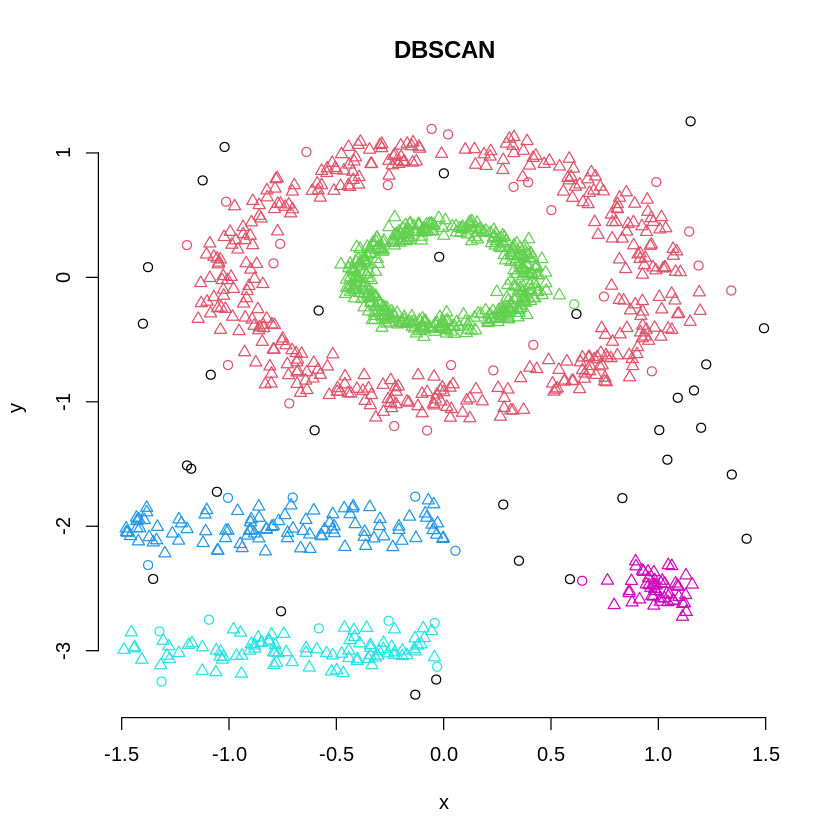

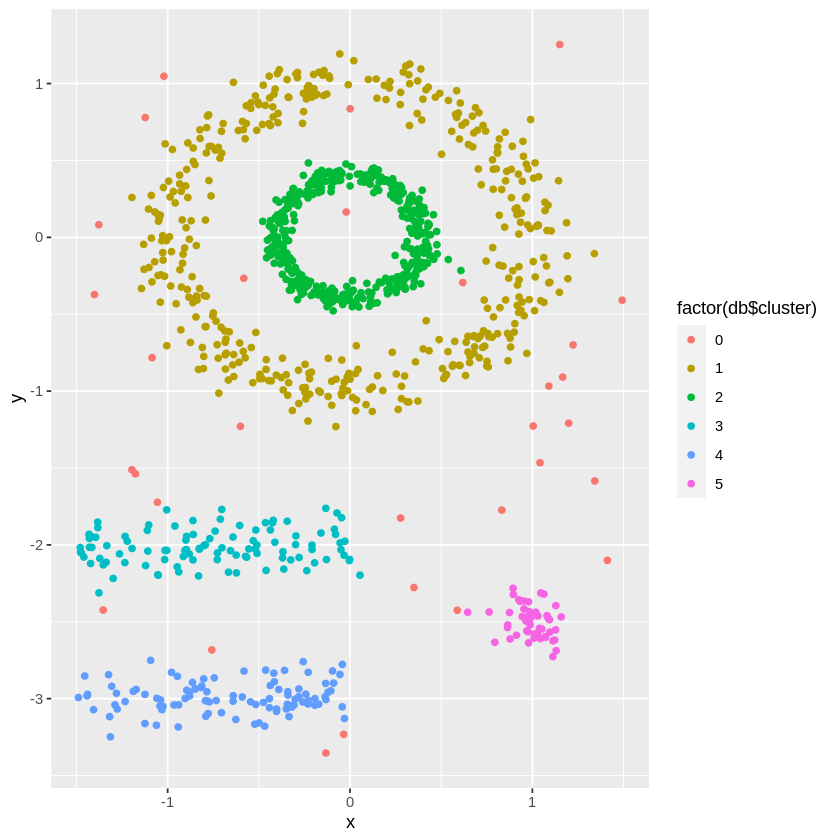

In [4]:
# Plot DBSCAN results
plot(db, df, main = "DBSCAN", frame = FALSE)

# OR 

ggplot(df) + geom_point(aes(x=x,y=y, color=factor(db$cluster)))

Consider the plot above, and contemplate the result you would expect from k-means.

 * What K would you pick for k-means?
 * What do you expect to happen?  
 
Ponder the above questions, then run the cell below.

In [17]:
# Apply kmeans clustering algorithm on df using a 5 clusters.
km.fit = kmeans(df, 17, nstart = 20)

# Clustering results
summary(km.fit)

             Length Class  Mode   
cluster      1100   -none- numeric
centers        34   -none- numeric
totss           1   -none- numeric
withinss       17   -none- numeric
tot.withinss    1   -none- numeric
betweenss       1   -none- numeric
size           17   -none- numeric
iter            1   -none- numeric
ifault          1   -none- numeric

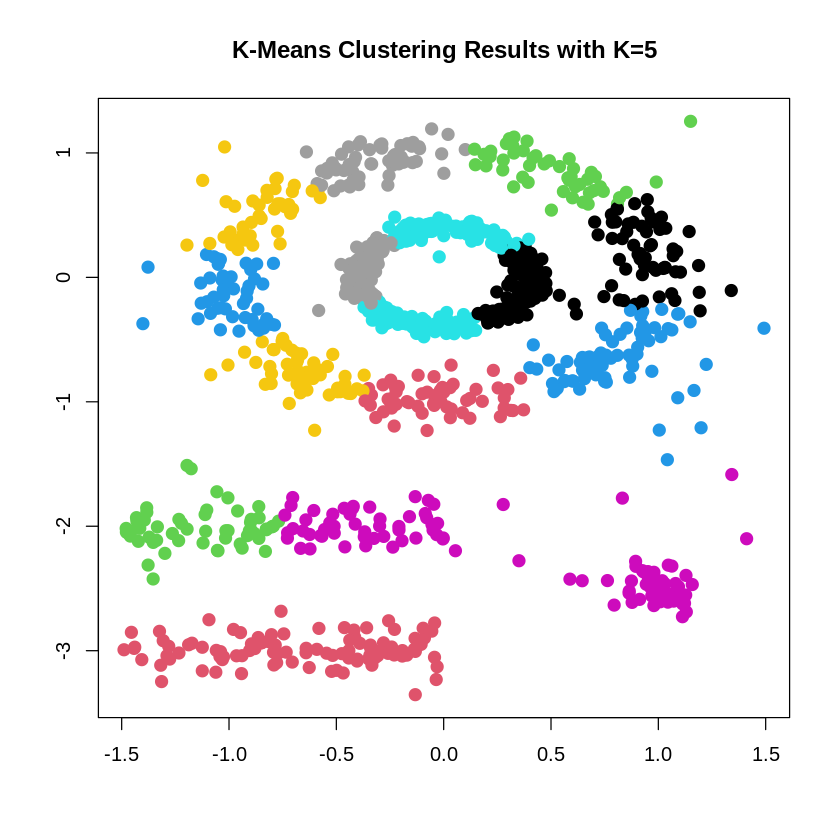

In [18]:
plot(df, col = (km.fit$cluster + 1), main = "K-Means Clustering Results with K=5", xlab = "", ylab= "", 
     pch = 20, cex = 2)

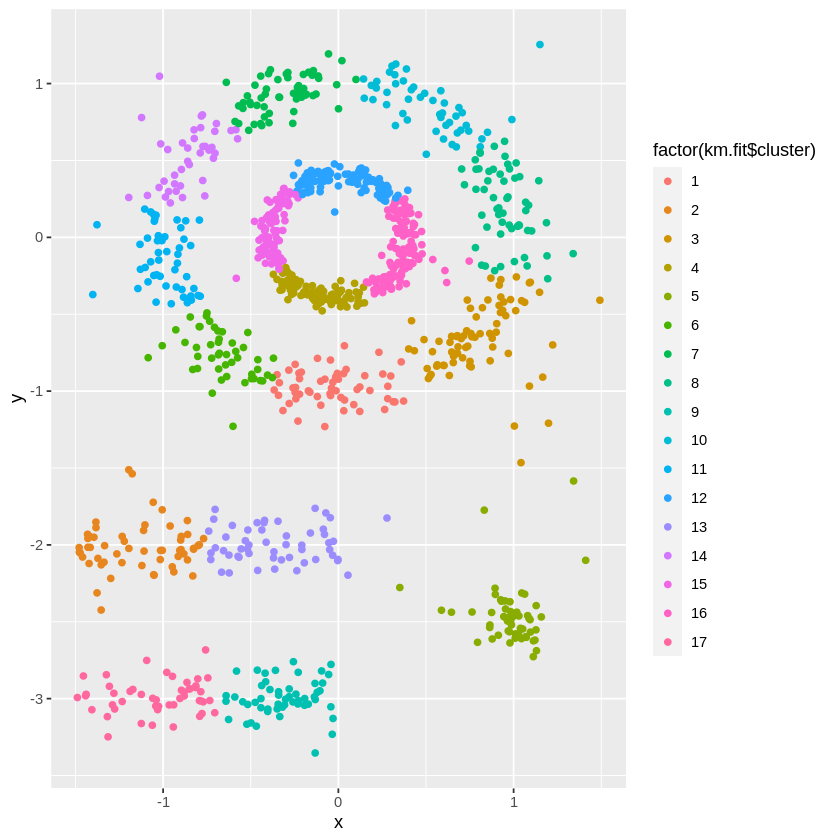

In [19]:
ggplot(df) + geom_point(aes(x=x,y=y, color=factor(km.fit$cluster)))

Compare the results of clustering with K-means and DBSCAN. 
Is this what you expected from k-means?

Go back to the code above and change the K value for k-means to examine the different results you could get.

We can see from the image below that DBSCAN performs better for the dataset and can identify a more intuitive 
set of clusters compared to k-means algorithms.

<img src="../images/kmeans_and_dbscan.JPG">

Now let's look at the internal information from the DBSCAN object that was produced.

In [20]:
# Print DBSCAN
print(db)

dbscan Pts=1100 MinPts=5 eps=0.15
        0   1   2   3  4  5
border 31  24   1   5  7  1
seed    0 386 404  99 92 50
total  31 410 405 104 99 51


In the table above, the column names represent the cluster number. 
Cluster 0 corresponds to outliers which are denoted using hollow circles in DBscab graph.
Note, cluster 0 has no seed points and only border points.

DBSCAN can find a suitable number of clusters for us; however there are still some parameters that have to be fed into the algorithm.
DBSCAN requires the user to specify the optimal values for `eps` and `MinPts` parameters. 
The values used for `eps` (0.15) and `MinPts` (5) depends on user. 
The choice of $\epsilon$ could be a disadvantage for DBSCAN as it is sensitive to $\epsilon$ when 
clusters have different densities. 


- If $\epsilon$ is too small, sparser clusters will be defined as noise. 
- If $\epsilon$ is too large, denser clusters may be merged together. 


So, if there are clusters with different local densities, 
then a single $\epsilon$ value will not give good results.

---

<span style="color:#ce7721; font-size:18px; font-weight:700">  Determine the optimal eps value

Numerous techniques to choose an optimal `eps` have been developed.
One approach is as follows.
The k-nearest neighbor distances for the matrix of points are calculated as the average of the 
distances of every point to its k nearest neighbors. 
The value of k depends upon the user and typically corresponds to MinPts.

These k-distances are plotted in an ascending order to determine the optimal eps parameter. 
The function `kNNdistplot()` in `dbscan` package is used to draw the k-distance plot.

In [9]:
library(dbscan)


Attaching package: ‘dbscan’


The following object is masked from ‘package:fpc’:

    dbscan




`minPts` is often chosen as dimensionality of the data +1. 
Using the kNN distance plot below we can decide on epsilon value using the knee in the kNN distance plot.

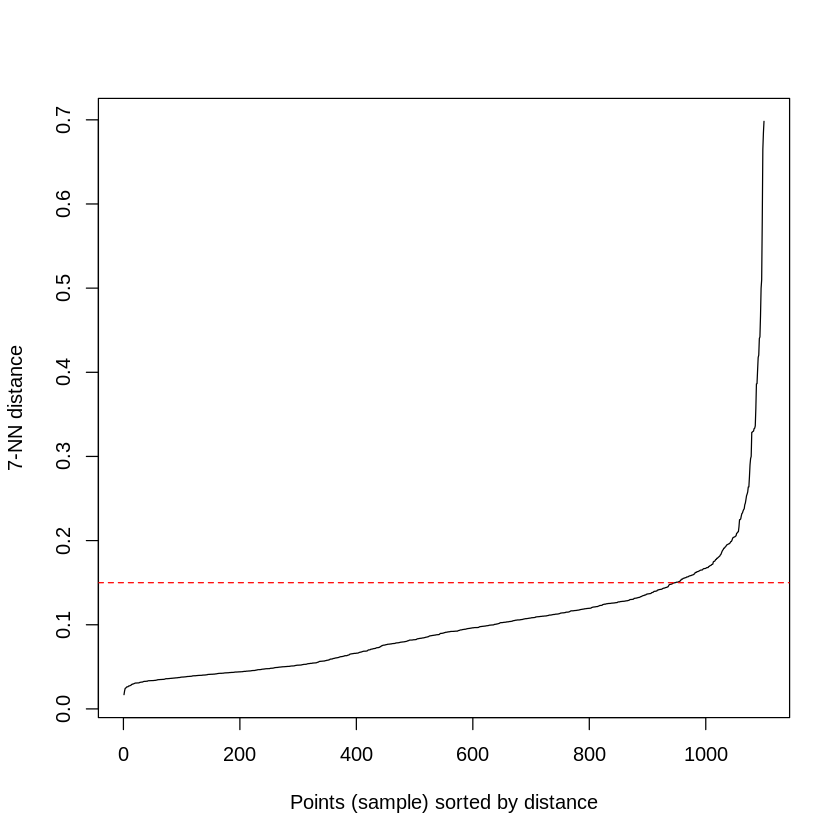

In [10]:
dbscan::kNNdistplot(df, k =  7)
abline(h = 0.15, lty = 2,col='red')

It can be seen that the optimal eps value is around a distance of 0.15.

## <span style="background:yellow">YOUR TURN</span>


The **ruspini_scaled data** in package _cluster_ is a very simple data set with well separated clusters. 
Let's fit DBSCAN clustering model on that dataset.

In [11]:
data(ruspini, package="cluster")

In [12]:
head(ruspini)

,x,y
,<int>,<int>
1,4,53
2,5,63
3,10,59
4,9,77
5,13,49
6,13,69


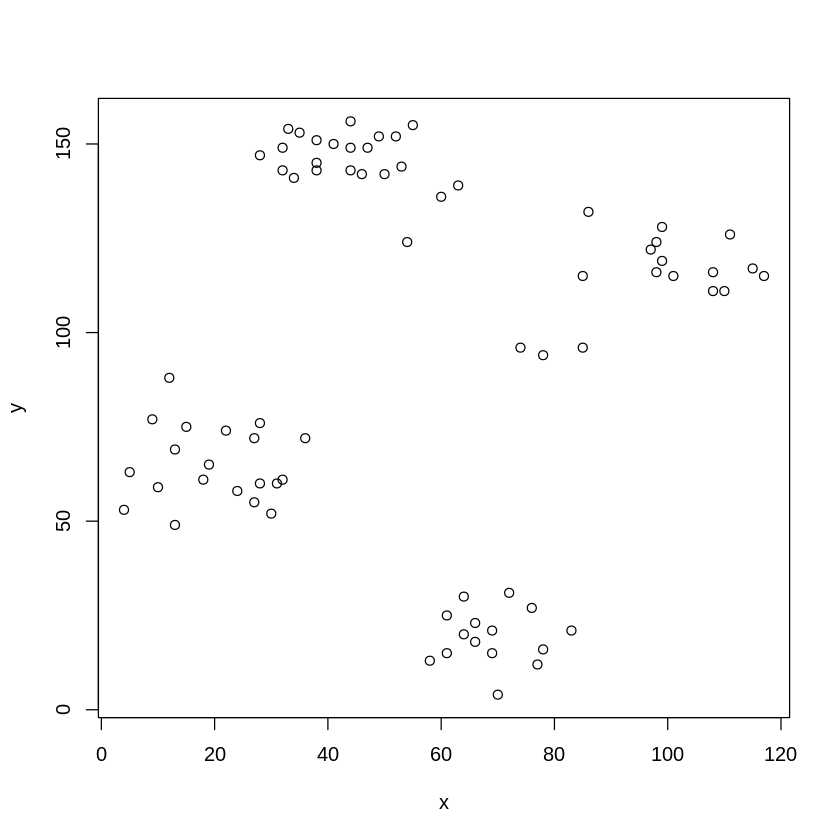

In [13]:
plot(ruspini)

Standardize the data to zero mean and unit standard deviation to prevent 
an attribute with a large range dominating others in the distance calculation.

In [21]:
ruspini_scaled <- as.data.frame(scale(ruspini))


Find `eps` value for ruspini_scaled data. 

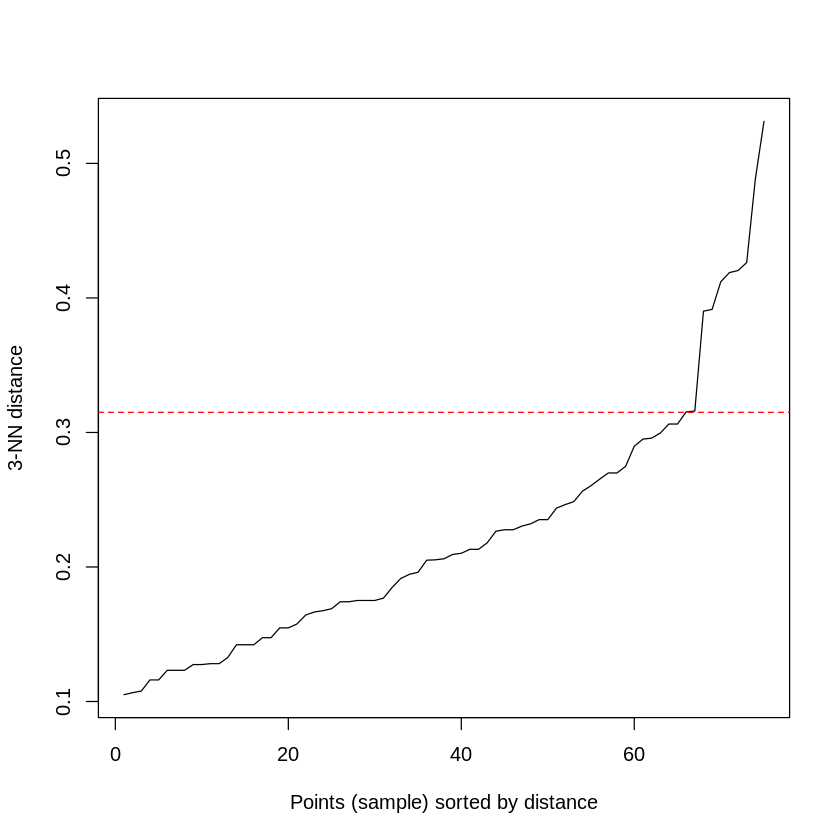

In [30]:
dbscan::kNNdistplot(ruspini_scaled, k=3)
abline(h = 0.315, lty = 2, col="red")


Fit `dbscan` model on ruspini_scaled using the eps value found above. 

In [43]:
db1 <- dbscan(ruspini_scaled, eps = 0.315, MinPts = 3)
db2 <- dbscan(ruspini_scaled, eps = 0.39, MinPts = 4)
db3 <- dbscan(ruspini_scaled, eps = 0.5, MinPts = 4)


Warning message in dbscan(ruspini_scaled, eps = 0.315, MinPts = 3):
“converting argument MinPts (fpc) to minPts (dbscan)!”
Warning message in dbscan(ruspini_scaled, eps = 0.39, MinPts = 4):
“converting argument MinPts (fpc) to minPts (dbscan)!”
Warning message in dbscan(ruspini_scaled, eps = 0.5, MinPts = 4):
“converting argument MinPts (fpc) to minPts (dbscan)!”


In [44]:
str(db1)
str(db2)
str(db3)


List of 3
 $ cluster: int [1:75] 1 1 1 1 1 1 1 1 1 1 ...
 $ eps    : num 0.315
 $ minPts : num 3
 - attr(*, "class")= chr [1:2] "dbscan_fast" "dbscan"
List of 3
 $ cluster: int [1:75] 1 1 1 1 1 1 1 1 1 1 ...
 $ eps    : num 0.39
 $ minPts : num 4
 - attr(*, "class")= chr [1:2] "dbscan_fast" "dbscan"
List of 3
 $ cluster: int [1:75] 1 1 1 1 1 1 1 1 1 1 ...
 $ eps    : num 0.5
 $ minPts : num 4
 - attr(*, "class")= chr [1:2] "dbscan_fast" "dbscan"


Plot the clusters formed with dbscan. 

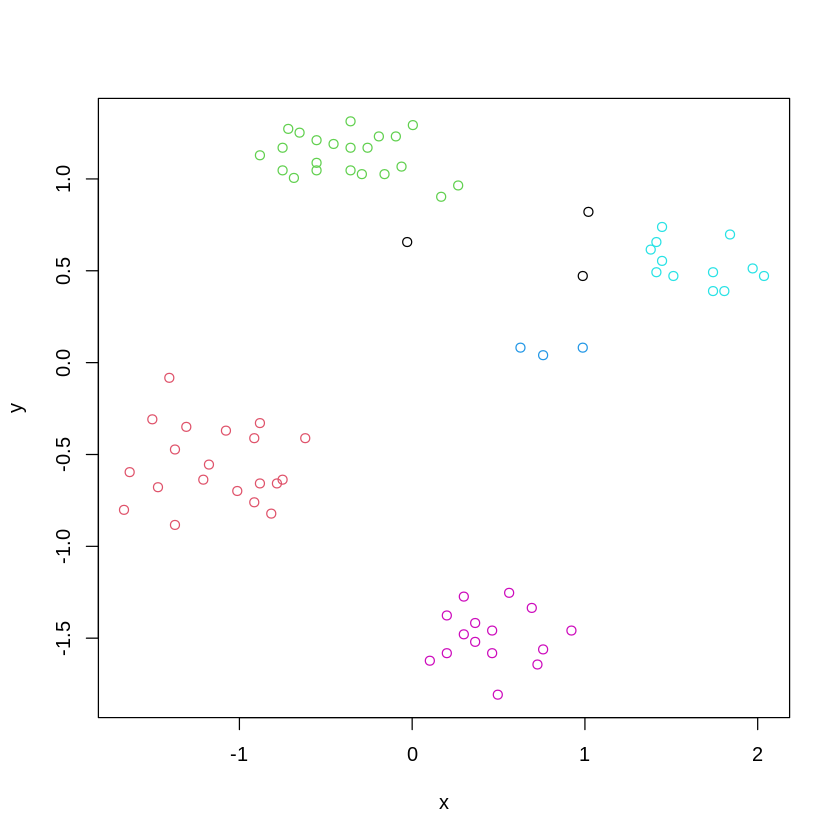

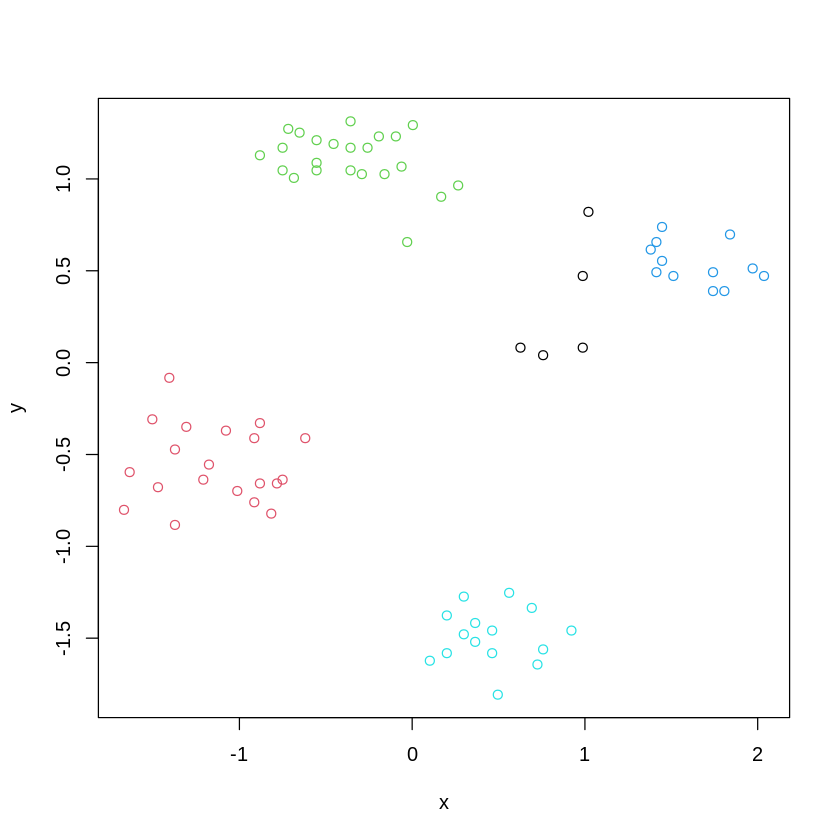

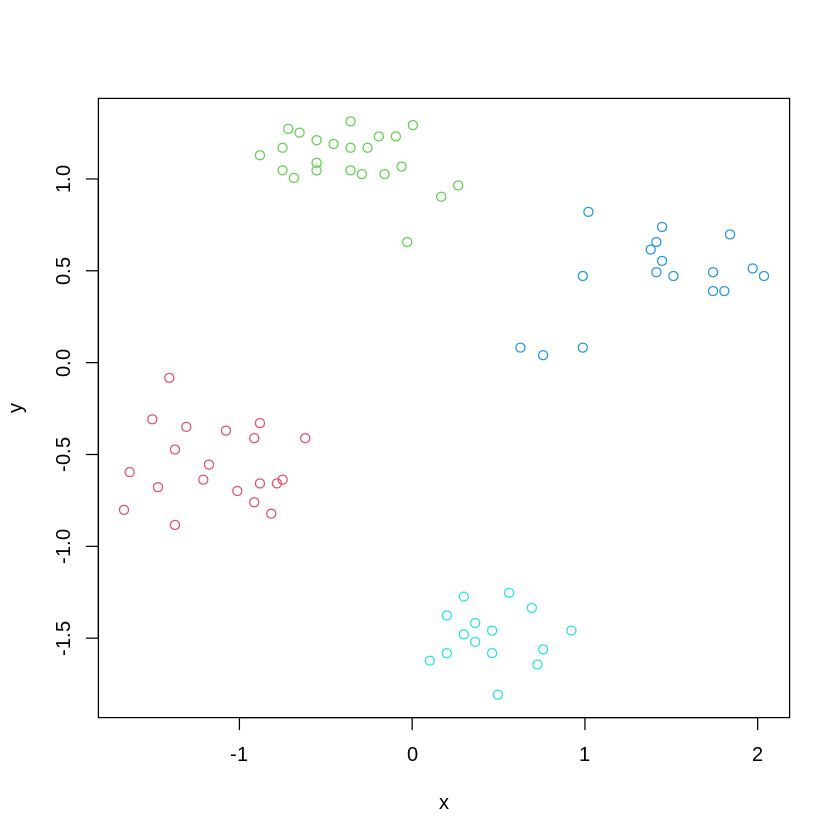

In [45]:
plot(ruspini_scaled, col=db1$cluster+1)
plot(ruspini_scaled, col=db2$cluster+1)
plot(ruspini_scaled, col=db3$cluster+1)


DBSCAN package has alternative visualization to view the clusters formed. The same clusters as those above can be visualized using hullplot as shown below. 

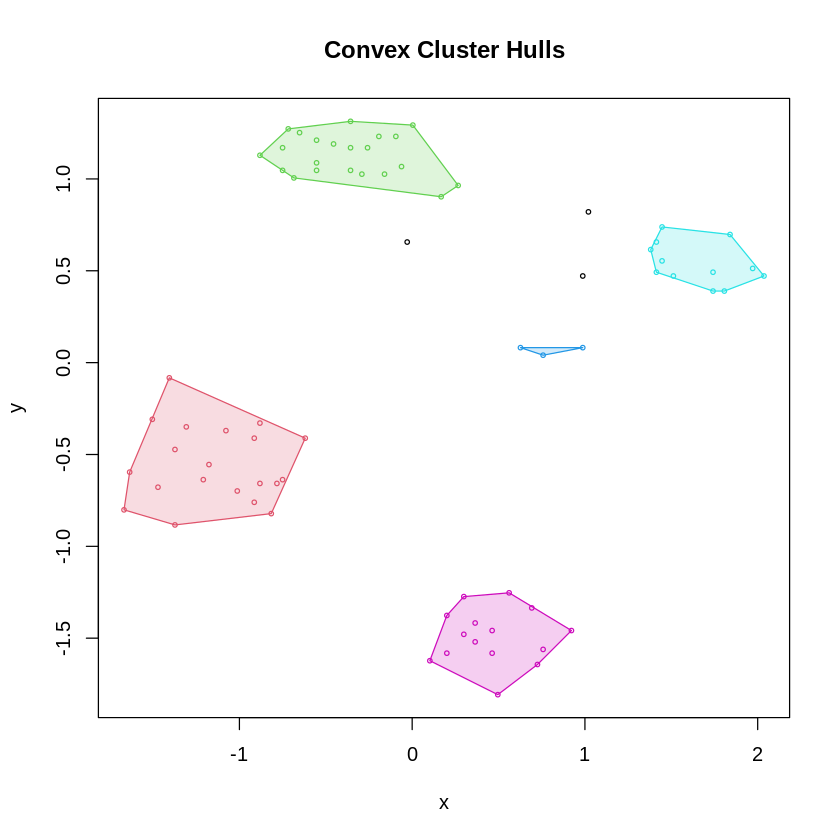

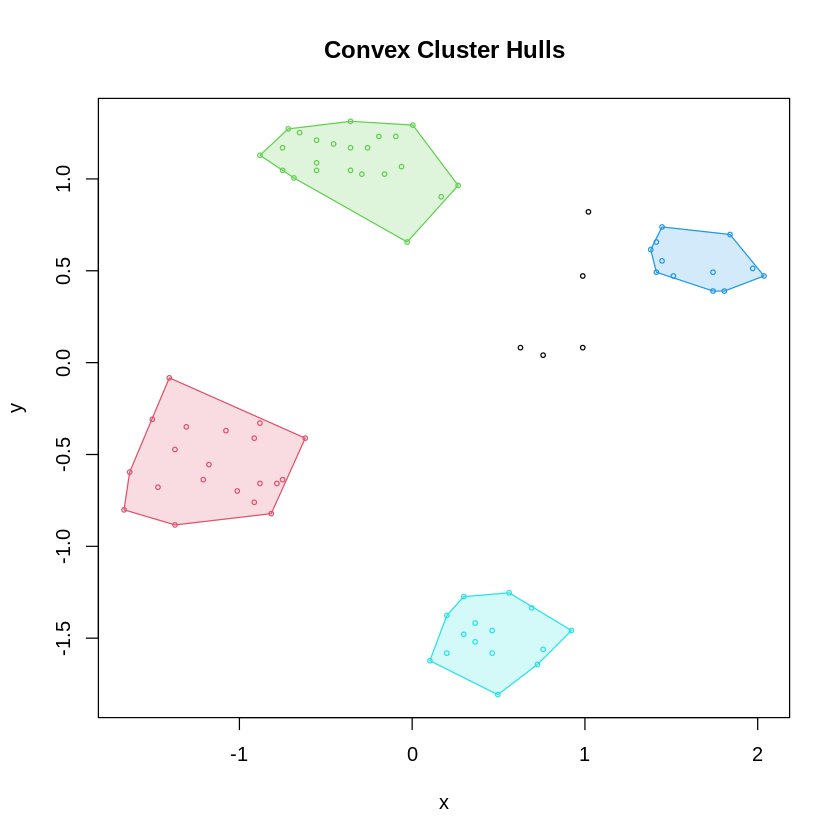

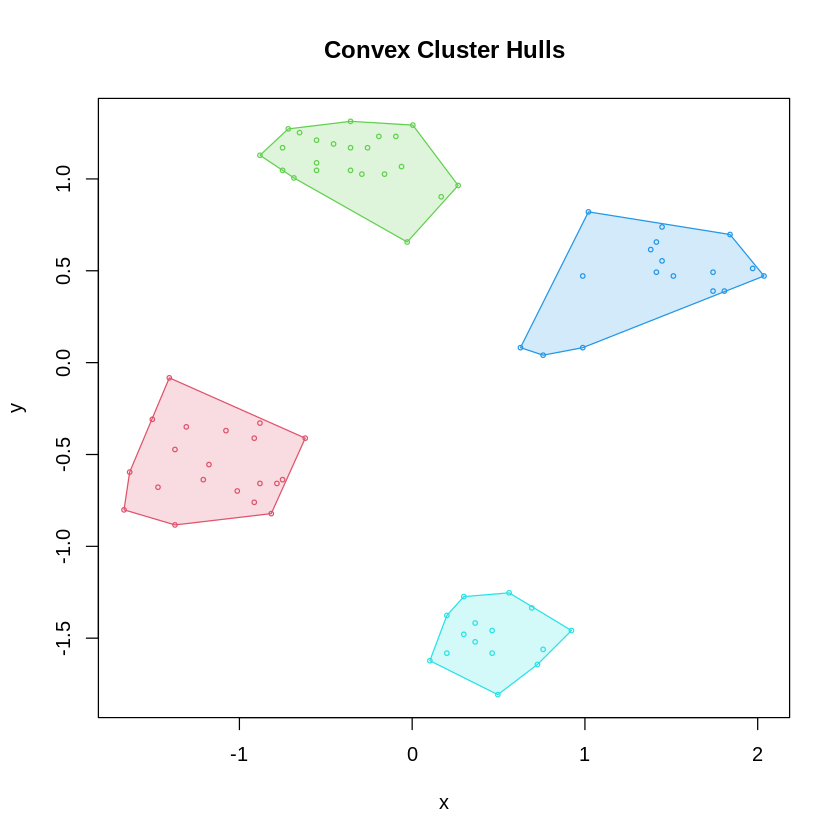

In [46]:
hullplot(ruspini_scaled, db1)
hullplot(ruspini_scaled, db2)
hullplot(ruspini_scaled, db3)


Try a different eps (neighborhood size) and MinPts (minimum of points needed for core cluster) to see how clusters differ. 


dig deeper: [dbscan: Fast Density-based Clustering with R](https://cran.r-project.org/web/packages/dbscan/vignettes/dbscan.pdf)

# Save your notebook!